# 1- Importation et préparation des données

In [2]:
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import statistics as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import os

print(os.getcwd())

data_temperature = pd.read_table('../data/observatoire-geneve/TG_STAID000241.txt',sep = ',',
                                names = ['SOUID','DATE','TG','Q_TG'], skiprows = range(0,20))
print(data_temperature.head())
data_temperature.drop(data_temperature[ data_temperature['Q_TG'] == 9 ].index, inplace = True)
data_temperature['Year'] = [int(str(d)[:4]) for d in data_temperature.DATE]
data_temperature['Month'] = [int(str(d)[4:6]) for d in data_temperature.DATE]
data_temperature['Day'] = [int(str(d)[6:8]) for d in data_temperature.DATE]

#Compute the day of the year for each year
day_of_year = np.array(len(data_temperature['Day']))

adate = [datetime.strptime(str(date),"%Y%m%d") for date in data_temperature.DATE]
data_temperature['Day_of_year'] = [d.timetuple().tm_yday for d in adate]
data_temperature.TG = data_temperature.TG/10.
print(data_temperature)

/Users/kieranvaudaux/Documents/SCV/SCV_project1/notebooks
    SOUID      DATE  TG  Q_TG
0  100745  19010101  49     0
1  100745  19010102  28     0
2  100745  19010103  -2     0
3  100745  19010104 -51     0
4  100745  19010105 -69     0
        SOUID      DATE    TG  Q_TG  Year  Month  Day  Day_of_year
0      100745  19010101   4.9     0  1901      1    1            1
1      100745  19010102   2.8     0  1901      1    2            2
2      100745  19010103  -0.2     0  1901      1    3            3
3      100745  19010104  -5.1     0  1901      1    4            4
4      100745  19010105  -6.9     0  1901      1    5            5
...       ...       ...   ...   ...   ...    ...  ...          ...
44039  100741  20210729  21.4     0  2021      7   29          210
44040  100741  20210730  21.4     0  2021      7   30          211
44041  100741  20210731  19.2     0  2021      7   31          212
44042  100741  20210801  15.2     0  2021      8    1          213
44043  100741  20210802  

In [4]:
df = data_temperature

# 2- Analyse exploratoire des données comme des Time Series

## 2.1- Seasonal Plot of temperature

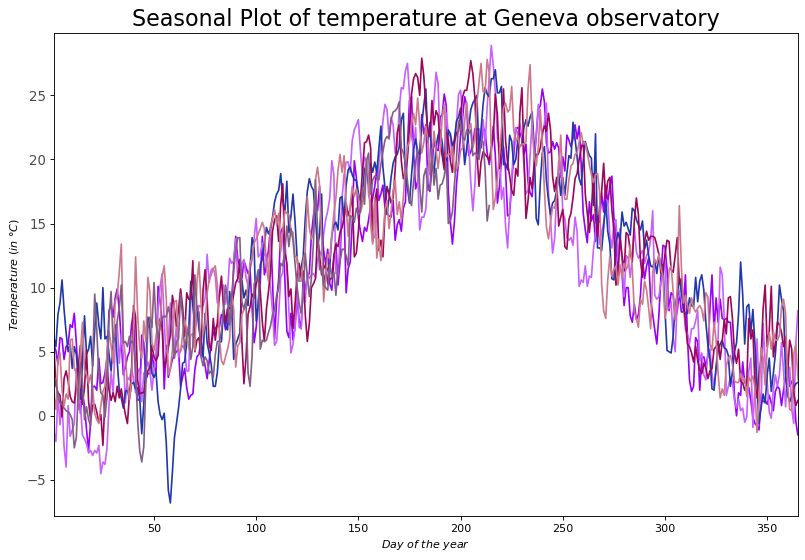

In [25]:
df1 = df[df.Year>2015]
years = df1['Year'].unique()
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)

for i, y in enumerate(years):        
    plt.plot('Day_of_year','TG',data=df1[df1.Year==y], color=mycolors[i], label=y)
        

# Decoration
plt.gca().set(xlim=(1, 365), ylim=(min(df1.TG) - 1, max(df1.TG) + 1),
              ylabel='$Temperature\ (in\ °C)$', xlabel='$Day\ of\ the\ year$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of temperature at Geneva observatory", fontsize=20)
plt.show()

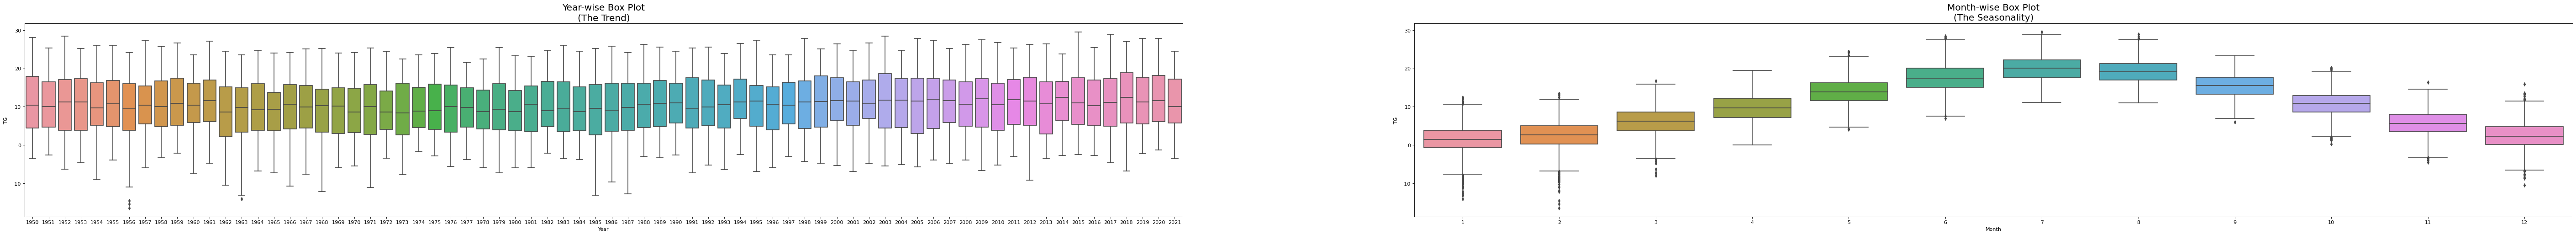

In [26]:
df1 = df[df.Year >= 1950]
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(90,7), dpi= 80)
sns.boxplot(x='Year', y='TG', data=df1, ax=axes[0])
sns.boxplot(x='Month', y='TG', data=df1)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

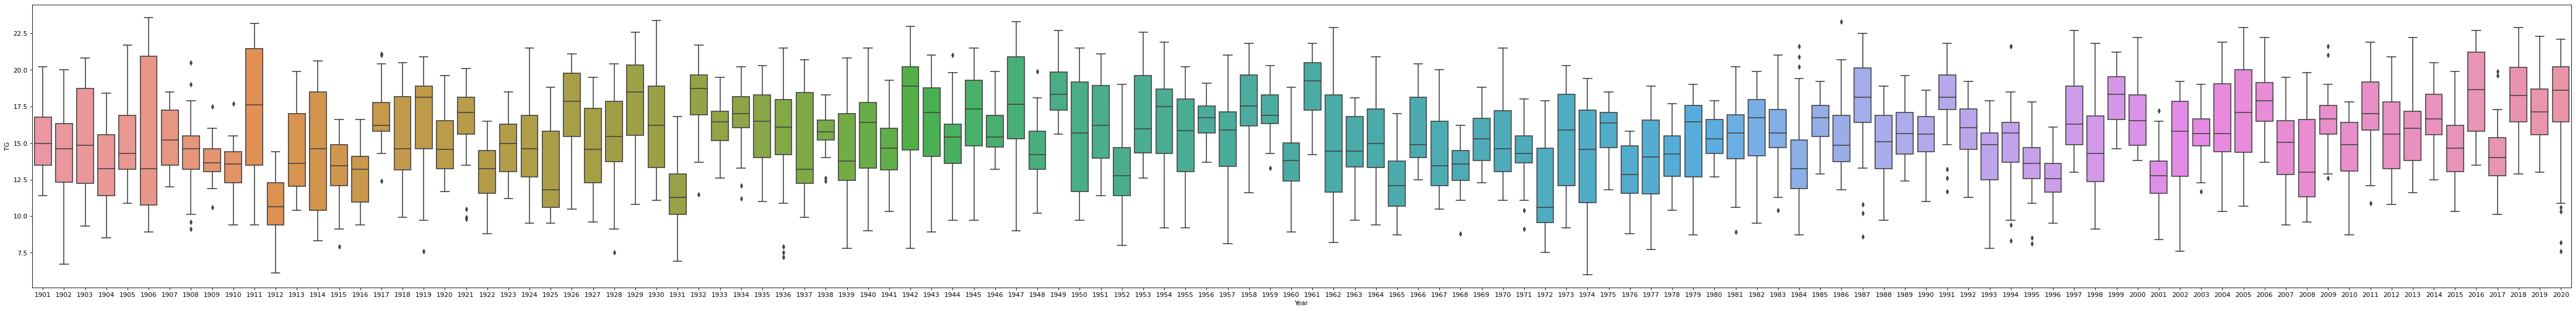

In [27]:
# Draw Plot
plt.figure(figsize=(70,8), dpi= 80)
sns.boxplot(x='Year', y='TG', data=df[df.Month == 9] )

#plt.plot(years,[st.mean(df.TG[df.Year == year]) for year in years])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

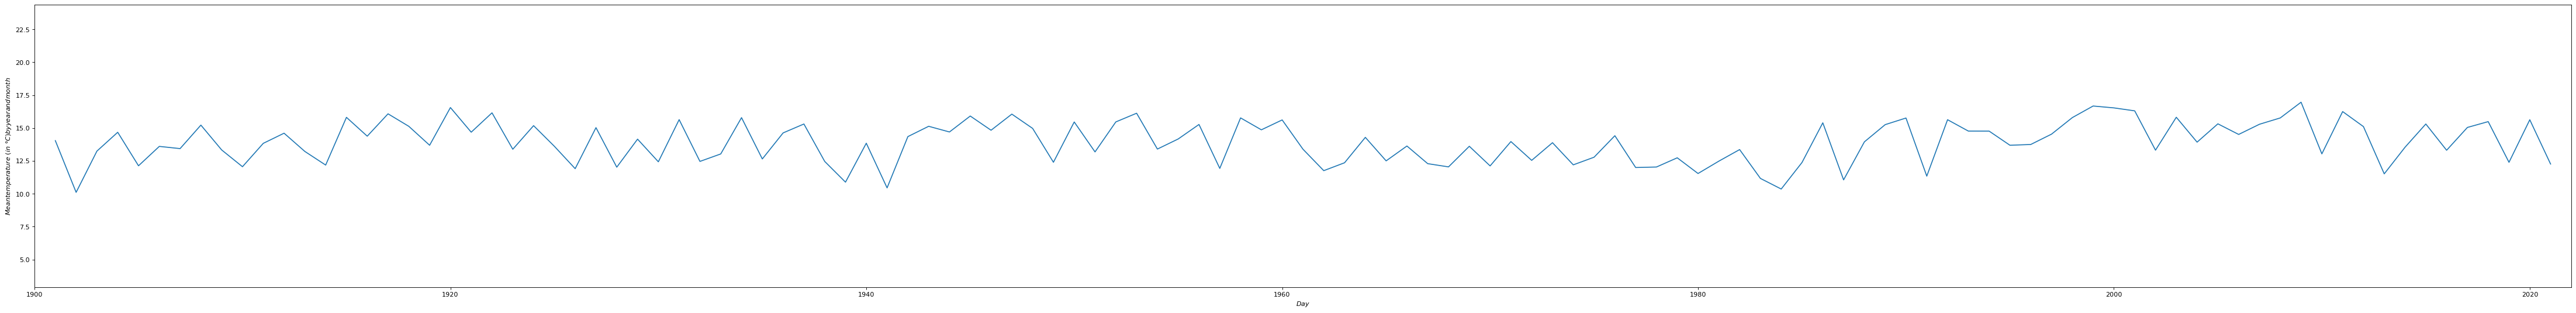

In [28]:
years = df['Year'].unique()
# Draw Plot
plt.figure(figsize=(70,8), dpi= 80)
month = 5
plt.plot(years,[st.mean(df.TG[(df.Year == year) & (df.Month == month)]) for year in years])

# Set Title
plt.gca().set(xlim=(1900, 2022), ylim=(min(df.TG[df.Month == month]), max(df.TG[df.Month == month])),
              ylabel='$Mean temperature\ (in\ °C) by year and month$', xlabel='$Day$')
plt.show()

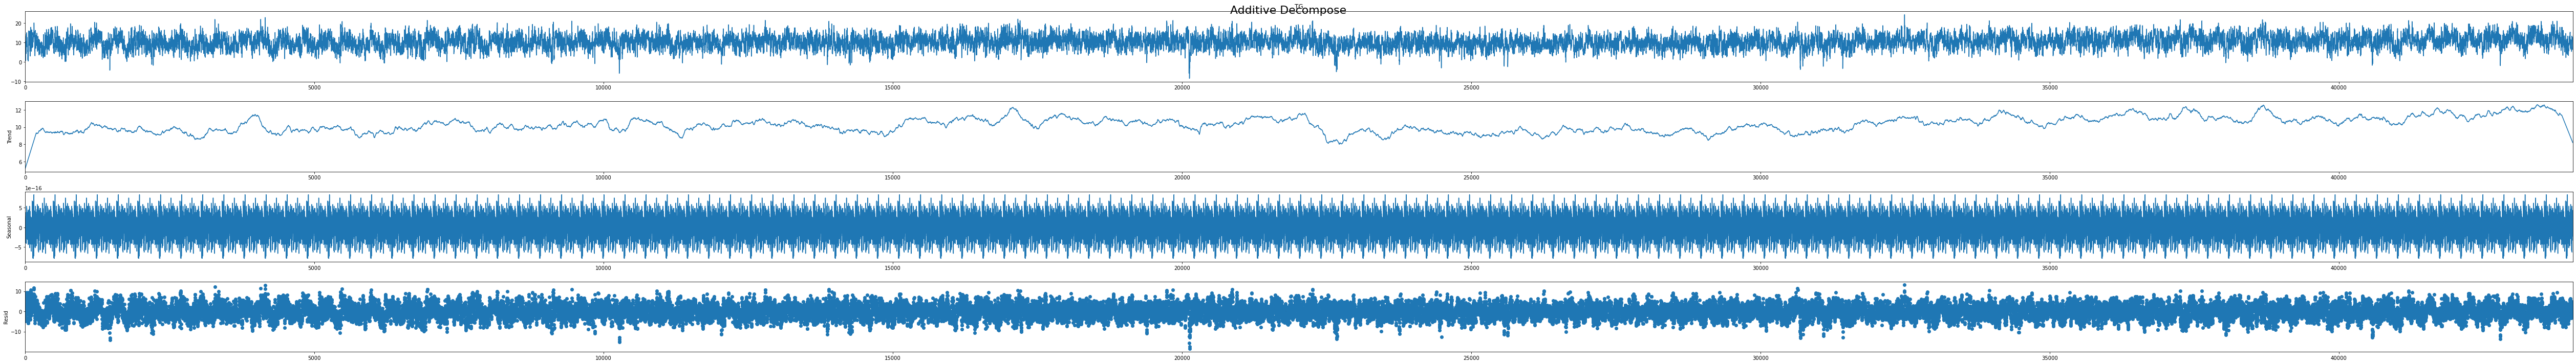

10.276409211597818


<AxesSubplot:>

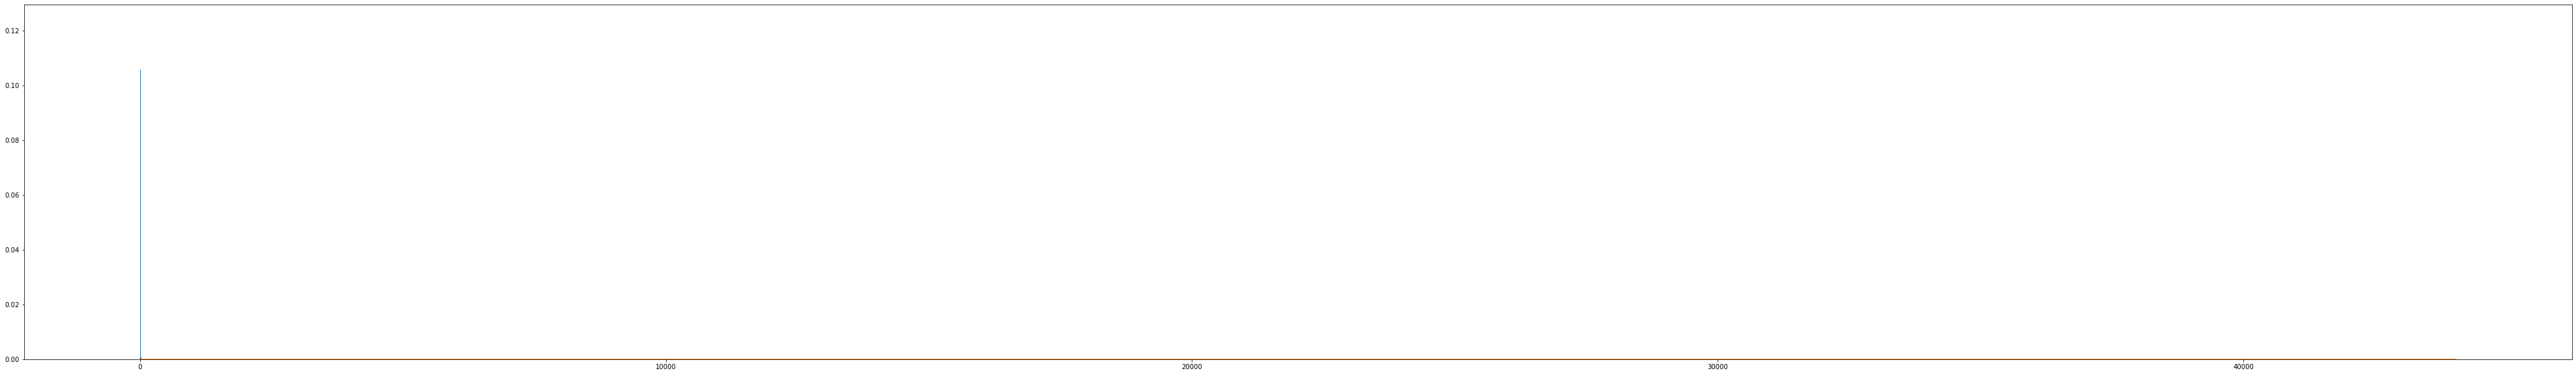

In [8]:
# Additive Decomposition
result_add = seasonal_decompose(df['TG'], model='additive', extrapolate_trend=7, period = 365,two_sided=True)

plt.rcParams.update({'figure.figsize': (70,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show() 
tp = data_temperature
tp.TG = tp.TG - result_add.seasonal

print(np.mean(tp.TG))
tp.TG.hist(bins = 500, density = True)
result_add.seasonal.plot()

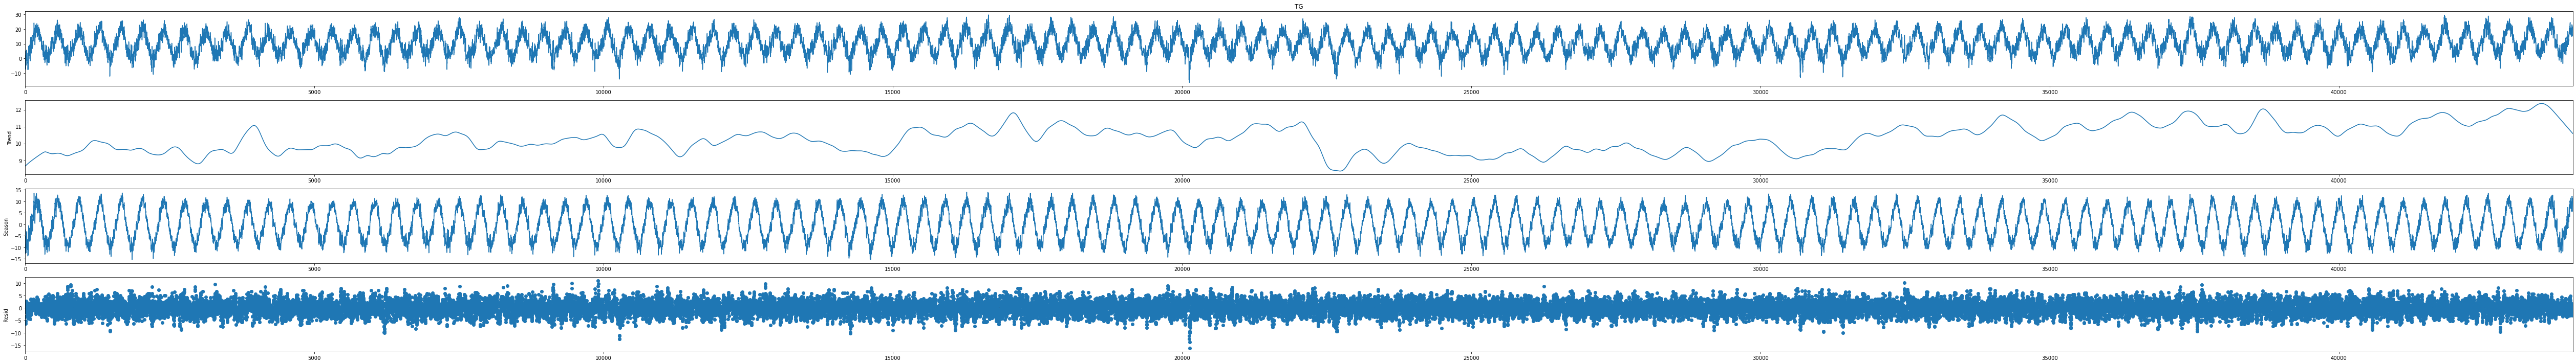

In [30]:
res = STL(df.TG, period = 365).fit()
res.plot()
plt.show()


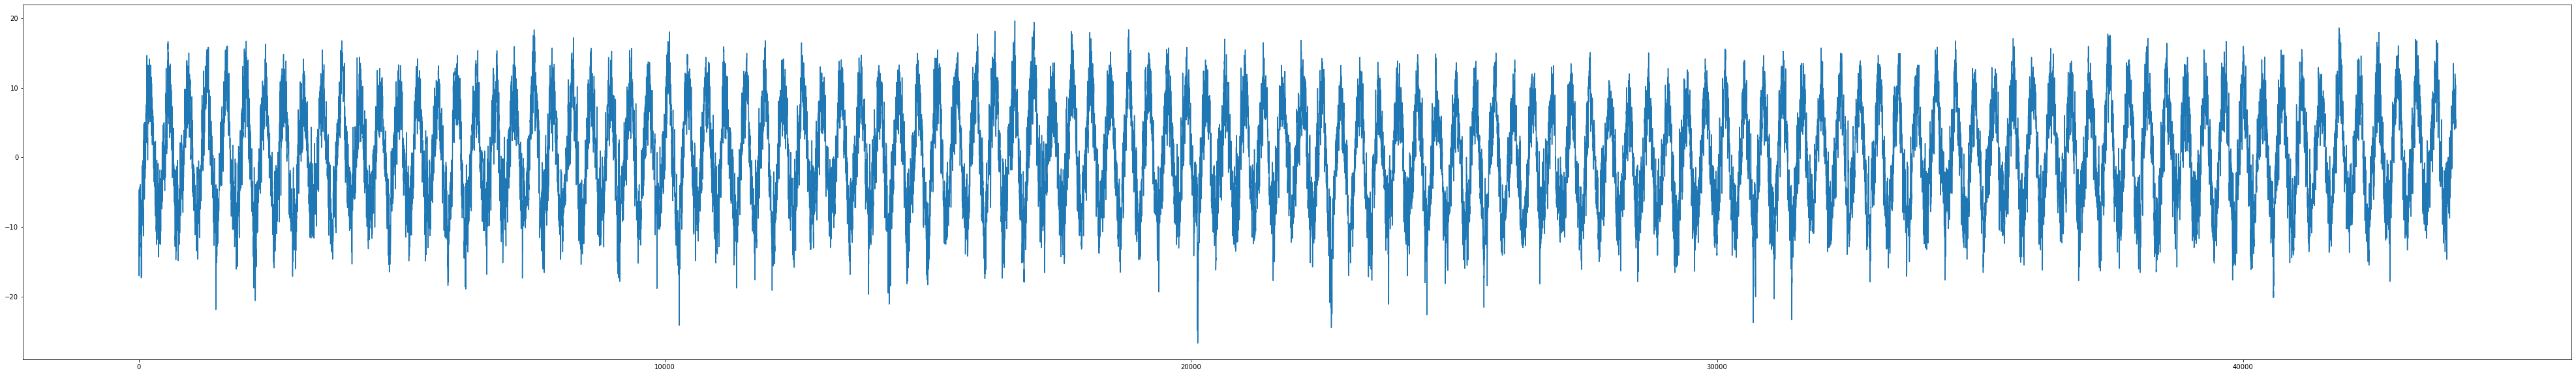

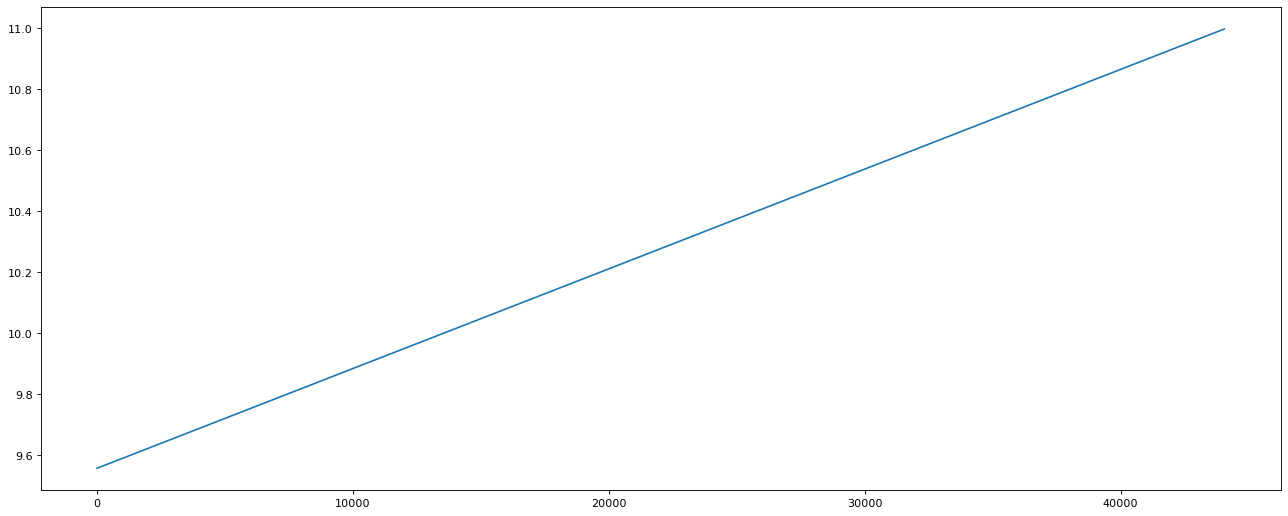

In [31]:
# Using scipy: Subtract the line of best fit
detrended1 = sc.signal.detrend(df.TG)
trend1 = df.TG - detrended1

plt.plot(detrended1)
plt.show()
plt.figure(figsize=(20,8), dpi= 80)
plt.plot(trend1)
plt.show()

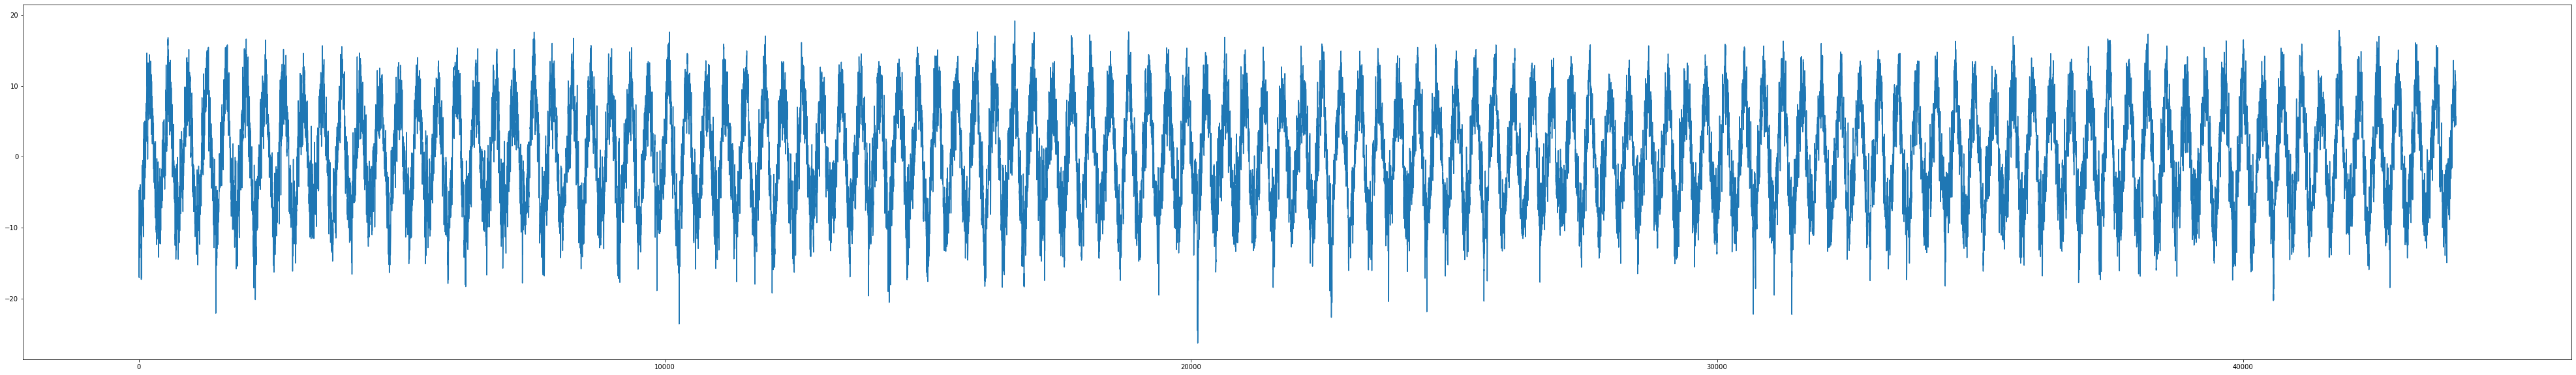

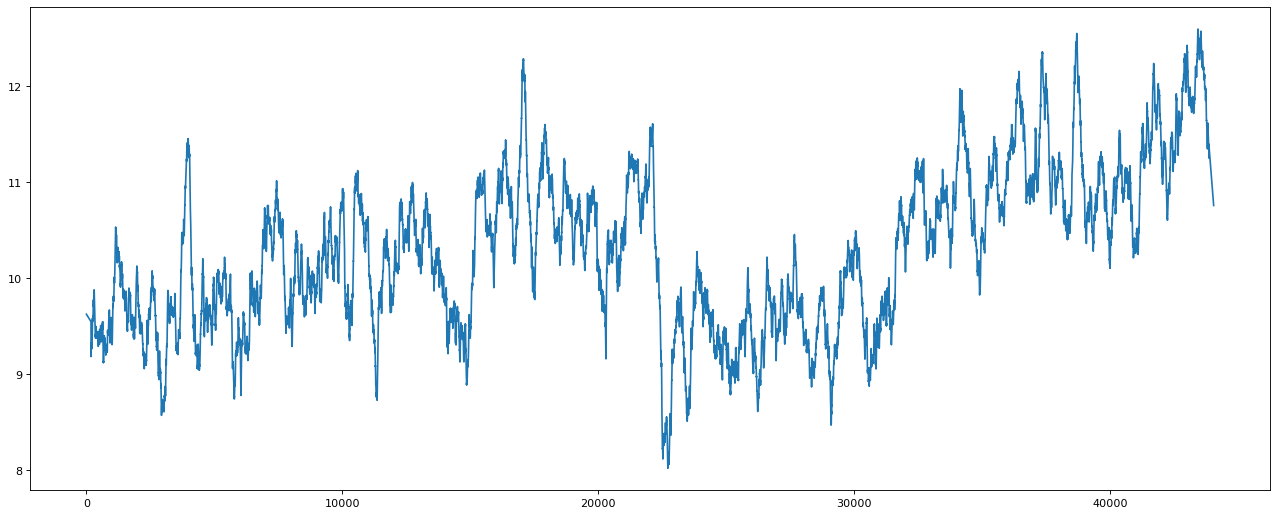

In [32]:
# Using statmodels: Subtracting the Trend Component.

result_add = seasonal_decompose(df.TG, model='additive', extrapolate_trend='freq',period = 365)
detrended = df.TG - result_add.trend
plt.plot(detrended)
plt.figure(figsize=(20,8), dpi= 80)
plt.plot(df.TG-detrended)


[ 1.          0.95946865 -0.04057756  0.16709001  0.08676412  0.07871117]


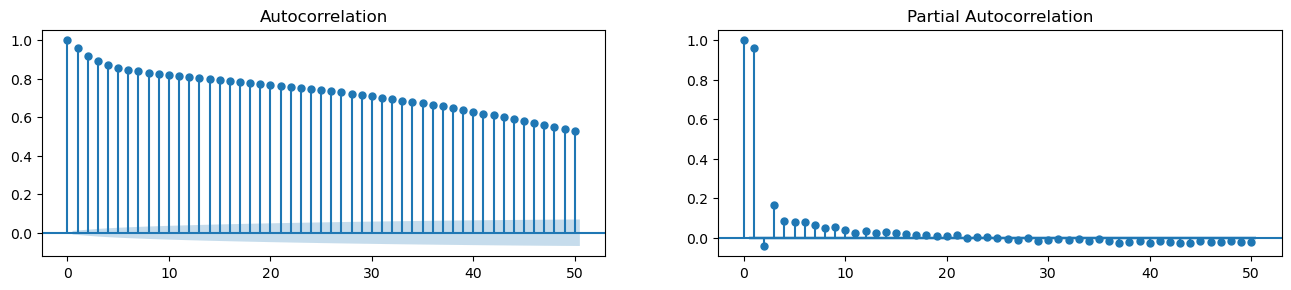

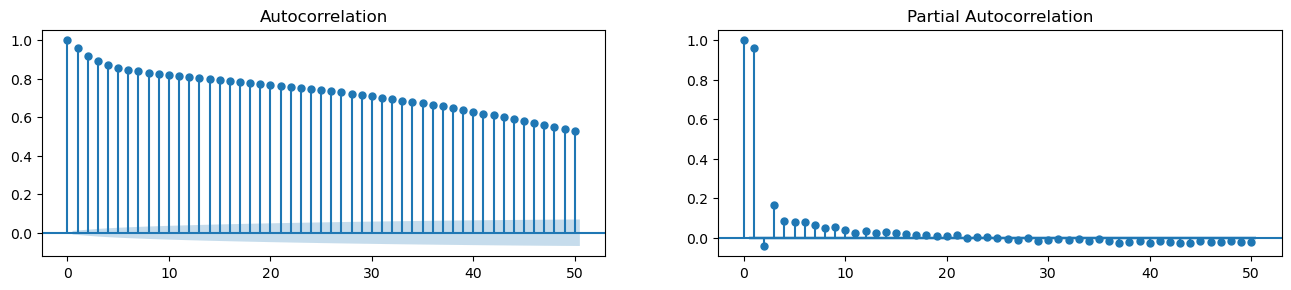

In [33]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
pacf_50 = pacf(df.TG, nlags=50)
print(pacf_50[:6])
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.TG, lags=50, ax=axes[0])
plot_pacf(df.TG, lags=50, ax=axes[1])

In [45]:
arma_mod = ARIMA(df.TG, order=(5, 0, 0)).fit()
print(arma_mod.params)

const     0.006724
ar.L1     0.960314
ar.L2    -0.198615
ar.L3     0.085386
ar.L4     0.005877
ar.L5     0.053741
sigma2    3.988086
dtype: float64


# Tests sur les Time Series pour tester l'hypothèse de normalité
Dans cette partie, nous allons tester une hypothèse de normalité $X\sim \mathcal{N}(\mu,\,\sigma^{2})$ sur la time serie des températures moyennes désaisonnalisé $X$.
Plus précisément, nous allons d'abord tester les hypothèses :
- $H_0: \mu > 0$
- $H_0: \mu < 0$
Cela nous permettra de savoir si 